In [4]:
import pandas as pd
import numpy as np
import time

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objs as go
from plotly.offline import iplot

In [6]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def calcError(origin, forecast):
    print("RMSE", RMSE(origin, forecast))
    print("MAPE", MAPE(origin, forecast))

In [7]:
def showPlot(true, prediction, model , test_set, size='M', save=False):
    if(size=='L'):
        plt.figure(figsize=(28, 10))
    plt.plot(true, color = 'red', label = 'Real')
    plt.plot(prediction, color = 'blue', label = 'Prediction')
    plt.title('Industry Elec Prediction' + model + ' ' + test_set + ' t' + str(t))
    plt.xlabel('Time')
    plt.ylabel('kW')
    plt.legend()
    if(save):
        plt.savefig('Image/' + model + '-' + test_set + '-' + str(t) + '.png')
    plt.show()

In [8]:
def augFeatures(data, features_select):
    data = pd.DataFrame(data[features_select])
    data.shape
    return data

In [9]:
from sklearn.preprocessing import MinMaxScaler
def normalize(data):
    sc = MinMaxScaler(feature_range = (0, 1))
    data_scaled = pd.DataFrame(sc.fit_transform(data))
    return sc, data_scaled 

def deNormalize(sc, value):
    value_unscaled = value * (sc.data_max_[0]-sc.data_min_[0]) + sc.data_min_[0]
    return value_unscaled 

In [10]:
def split_dataset(data, pastDay=7, futureDay=7):
    split_num_start = df[df['Date'] == trainFrom].index.item()
    split_num = df[df['Date'] == testFrom].index.item()
    split_num_end = df[df['Date'] == testTo].index.item()
    RawTrain = data[split_num_start:split_num]
    SelfTest = data[split_num_start:split_num - futureDay]
    SelfTruth = data[split_num_start + pastDay:split_num][0]
    RawTest = data[split_num - pastDay:split_num_end + 1 - futureDay]
    RawTrurh = data[split_num:split_num_end + 1][0]
    print("RawTrain", RawTrain.shape)
    print("RawTest, RawTrurh", RawTest.shape, RawTrurh.shape)
    print("SelfTest, SelfTruth", SelfTest.shape, SelfTruth.shape)
    return RawTrain, RawTest, RawTrurh, SelfTest, SelfTruth

In [11]:
def buildTrain(train, pastDay=7, futureDay=7):
    X_train, Y_train = [], []
    for i in range(pastDay, len(train)-futureDay):
        X_train.append(train[i-pastDay:i])
        Y_train.append(train[i:i+futureDay, 0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)  
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    return X_train, Y_train

In [12]:
def buildTest(test, pastDay=7, futureDay=7):
    X_test = []
    for i in range(0, int(len(test)/futureDay)-(pastDay-futureDay)):
        X_test.append(test[futureDay*i:futureDay*i+pastDay])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))  
    return X_test

In [13]:
def forecast(model, input_data, shape):
    forecast_temp = model.predict(input_data)
    forecast = []
    for i in range(forecast_temp.shape[0]):
        forecast= np.concatenate((forecast, forecast_temp[i]), axis=0)
    forecast = np.reshape(forecast, (shape[0], shape[1]))
    return forecast

In [14]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

Using TensorFlow backend.


In [15]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, Flatten, RepeatVector
from keras.layers import SimpleRNN, LSTM, CuDNNLSTM
from keras.layers import Dropout, BatchNormalization, Bidirectional
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [20]:
def create_model(X, Y, Xv, Yv):
    epochs = 1000
    model = Sequential()
    model.add(SimpleRNN(units = 200, activation='relu', input_shape = (X.shape[1], X.shape[2])))
    model.add(RepeatVector(7))
    model.add(SimpleRNN({{choice([8,50,100,150,200,250,300,350,400])}}, activation='relu', return_sequences=True))
    model.add(Dropout(0.183))
    if {{choice(['three', 'four'])}} == 'four':
        model.add(SimpleRNN(200, activation='relu', return_sequences=True))
        model.add(Dropout(0.183))      
    model.add(TimeDistributed(Dense(200, activation='relu')))
    model.add(Dropout({{uniform(0, 0.3)}}))
    model.add(Flatten())
    model.add(Dense(units = 7))
    model.compile(loss='mse', optimizer='adam')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=15, mode='min', verbose=0)
    earlyStop=EarlyStopping(monitor="val_loss", patience=20, mode="min", restore_best_weights=True)
    model.fit(X, Y, 
              epochs=epochs, batch_size=32, 
              verbose=0, 
              validation_data=(Xv, Yv), 
              callbacks=[reduce_lr, earlyStop])
    return {'loss': min(model.history.history['val_loss']), 'status': STATUS_OK, 'model': model}

In [21]:
def data():
    def augFeatures(data, features_select):
        data = pd.DataFrame(data[features_select])
        data.shape
        return data
    def normalize(data):
        sc = MinMaxScaler(feature_range = (0, 1))
        data_scaled = pd.DataFrame(sc.fit_transform(data))
        return sc, data_scaled 
    def deNormalize(sc, value):
        value_unscaled = value * (sc.data_max_[0]-sc.data_min_[0]) + sc.data_min_[0]
        return value_unscaled 
    def split_dataset(data, pastDay=7, futureDay=7):
        split_num_start = df[df['Date'] == trainFrom].index.item()
        split_num = df[df['Date'] == testFrom].index.item()
        split_num_end = df[df['Date'] == testTo].index.item()
        RawTrain = data[split_num_start:split_num]
        SelfTest = data[split_num_start:split_num - futureDay]
        SelfTruth = data[split_num_start + pastDay:split_num][0]
        RawTest = data[split_num - pastDay:split_num_end + 1 - futureDay]
        RawTrurh = data[split_num:split_num_end + 1][0]
        print("RawTrain", RawTrain.shape)
        print("RawTest, RawTrurh", RawTest.shape, RawTrurh.shape)
        print("SelfTest, SelfTruth", SelfTest.shape, SelfTruth.shape)
        return RawTrain, RawTest, RawTrurh, SelfTest, SelfTruth
    def splitData(X, Y, rate):
        X_train = X[int(X.shape[0]*rate):]
        Y_train = Y[int(Y.shape[0]*rate):]
        X_val = X[:int(X.shape[0]*rate)]
        Y_val = Y[:int(Y.shape[0]*rate)]
        return X_train, Y_train, X_val, Y_val
    def buildTrain(train, pastDay=7, futureDay=7):
        X_train, Y_train = [], []
        for i in range(pastDay, len(train)-futureDay):
            X_train.append(train[i-pastDay:i])
            Y_train.append(train[i:i+futureDay, 0])
        X_train, Y_train = np.array(X_train), np.array(Y_train)  
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
        return X_train, Y_train
    features = [
            'kW', 
            'PeakLoad(MW)_shift7', 
            'isHoliday_shift7', 
            'dayOfYear', 
            'weekUpdate_shift7', 
            'Temp_Taipei_shift7'
           ]
    trainFrom = '2017-01-04'
    trainTo = '2019-01-01'
    testFrom = '2019-01-02'
    testTo = '2019-09-24'
    df = pd.read_csv('Data/industryElec_processed_20160101_20190930.csv')
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    RawData = augFeatures(df, features)
    sc, RawData = normalize(RawData)
    Timesteps = 7
    OutputDay = 7
    RawTrain, RawTest, RawTrurh, SelfTest, SelfTruth  = split_dataset(RawData, Timesteps, OutputDay)
    X_train, Y_train = buildTrain(RawTrain.values, Timesteps, OutputDay)
    X, Y, Xv, Yv= splitData(X_train, Y_train, 0.1)
    return X, Y, Xv, Yv

In [22]:
tStart = time.time()

X, Y, Xv, Yv = data()

best_run, best_model = optim.minimize(model=create_model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=15,
                                      trials=Trials(),
                                      verbose=True,
                                      notebook_name='IndustryElec_(RNN_XT)_Hyperas')

print("Evalutation of best performing model:")
print(best_model.evaluate(Xv, Yv))
print(best_run)

tEnd = time.time()
print('Total time spent.....',tEnd - tStart, 'second')

RawTrain (728, 6)
RawTest, RawTrurh (266, 6) (266,)
SelfTest, SelfTruth (721, 6) (721,)
>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import time
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import plotly.graph_objs as go
except:
    pass

try:
    from plotly.offline import iplot
except:
    pass

try:
    from sklearn.preprocessing import MinMaxScaler
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice, uniform
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import Dense, TimeDistributed, Flatten, RepeatVector
except:
    pass

try:
    from keras.layers import SimpleRNN, LSTM, CuDNNLSTM
except:
    pass

try:
    

In [23]:
best_model.save('Best_Model_RNN_Deep_4.h5')

In [24]:
features = [
            'kW', 
            'PeakLoad(MW)_shift7', 
            'isHoliday_shift7', 
            'dayOfYear', 
            'weekUpdate_shift7', 
            'Temp_Taipei_shift7'
           ]
trainFrom = '2017-01-04'
trainTo = '2019-01-01'
testFrom = '2019-01-02'
testTo = '2019-09-24'
df = pd.read_csv('Data/industryElec_processed_20160101_20190930.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

RawData = augFeatures(df, features)
sc, RawData = normalize(RawData)

Timesteps = 7
OutputDay = 7

RawTrain, RawTest, RawTrurh, SelfTest, SelfTruth  = split_dataset(RawData, Timesteps, OutputDay)

X_train, Y_train = buildTrain(RawTrain.values, Timesteps, OutputDay)
S_test = buildTest(SelfTest.values, Timesteps, OutputDay)
X_test = buildTest(RawTest.values, Timesteps, OutputDay)

RawTrain (728, 6)
RawTest, RawTrurh (266, 6) (266,)
SelfTest, SelfTruth (721, 6) (721,)


In [25]:
t = 4
save = True
model_name = '(XT_RNN_2017_Hyperas_Deep)'

RMSE 6.947037978263248
MAPE 1.670633816645493


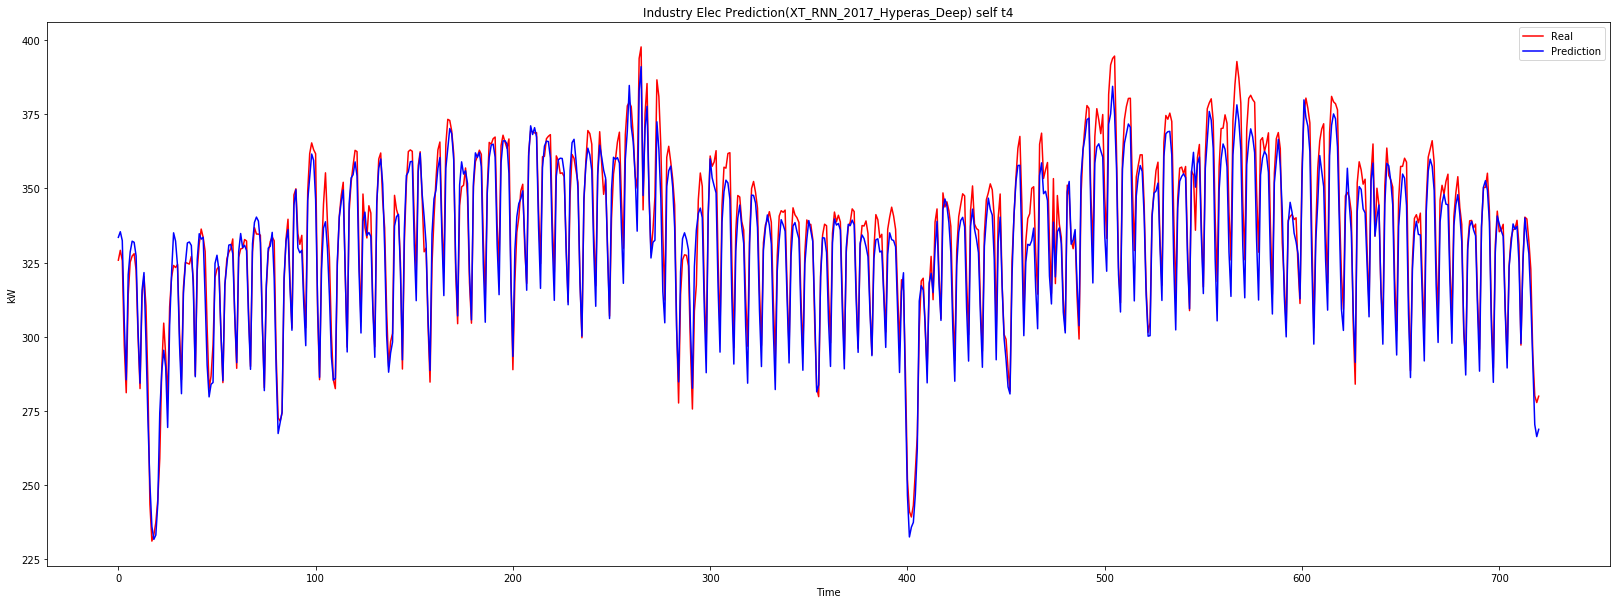

In [26]:
self_trurh = pd.DataFrame(SelfTruth)
self_trurh = deNormalize(sc, self_trurh.values)
self_predict = forecast(best_model, S_test, self_trurh.shape)
self_predict = deNormalize(sc, self_predict)
calcError(self_trurh, self_predict)
showPlot(self_trurh, self_predict, model_name , "self", size="L", save=save)

RMSE 10.599812721250945
MAPE 2.547713421584803


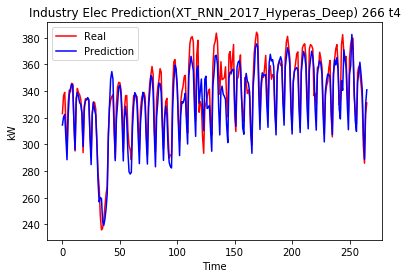

In [27]:
test_trurh = pd.DataFrame(RawTrurh)
test_trurh = deNormalize(sc, test_trurh.values)
test_predict = forecast(best_model, X_test, test_trurh.shape)
test_predict = deNormalize(sc, test_predict)
calcError(test_trurh, test_predict)
showPlot(test_trurh, test_predict, model_name , str(266), save=save)